In [130]:
%load_ext autoreload
%autoreload 2

# Ensure your Python version makes sense
import sys
sys.version

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import pandas as pd
import json, os


def plot(logdir, env, double_q, trials, col_name="Avg_Last_100_Episodes", sma=False):
    fig = plt.figure(figsize=(9,7))

    for path in trials:
        full_path = os.path.join(logdir, path)
        log_path = os.path.join(full_path,'log.txt')
        name = path.replace('NoFrameskip-v4','')
        data = pd.read_csv(log_path, sep='\t')  
        steps_million = data['Steps'] / 1e6
        if sma:
            plt.plot(steps_million, data[col_name].rolling(window=1).mean(), lw=1, label=name)
        else:
            plt.plot(steps_million, data[col_name], lw=1, label=name)
            

    # Bells and whistles
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.legend(loc='best', fontsize=20)
    plt.xlabel('Training Steps (in Millions)', fontsize=20)
    plt.ylabel(col_name, fontsize=20)
    if double_q:
        plt.title('{} Double DQN'.format(env), fontsize=24)
    else:
        plt.title('{} DQN'.format(env), fontsize=24)
    plt.tight_layout()
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


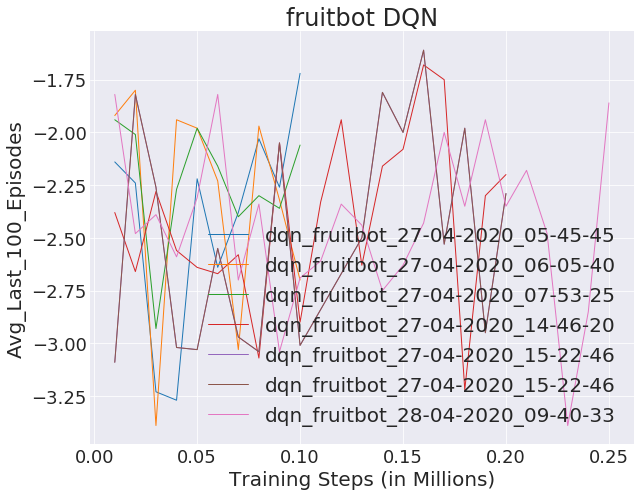

In [131]:
# for 100K-250K timesteps
trials = [
    'dqn_fruitbot_27-04-2020_05-45-45',
    'dqn_fruitbot_27-04-2020_06-05-40',
    'dqn_fruitbot_27-04-2020_07-53-25',
    'dqn_fruitbot_27-04-2020_14-46-20',
    'dqn_fruitbot_27-04-2020_15-22-46',
    'dqn_fruitbot_27-04-2020_15-22-46',
    'dqn_fruitbot_28-04-2020_09-40-33'
]

plot(logdir='data_dqn', env='fruitbot', double_q=False, trials=trials)

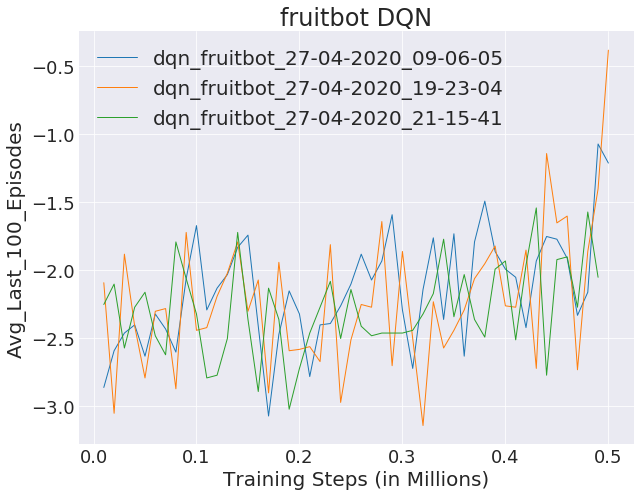

In [132]:
# 500k timesteps
trials = [
    'dqn_fruitbot_27-04-2020_09-06-05',
    'dqn_fruitbot_27-04-2020_19-23-04',
    'dqn_fruitbot_27-04-2020_21-15-41'
]

plot(logdir='data_dqn', env='fruitbot', double_q = False, trials=trials)

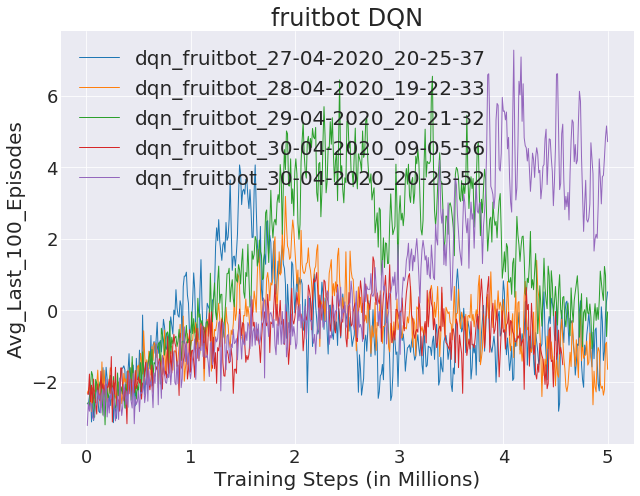

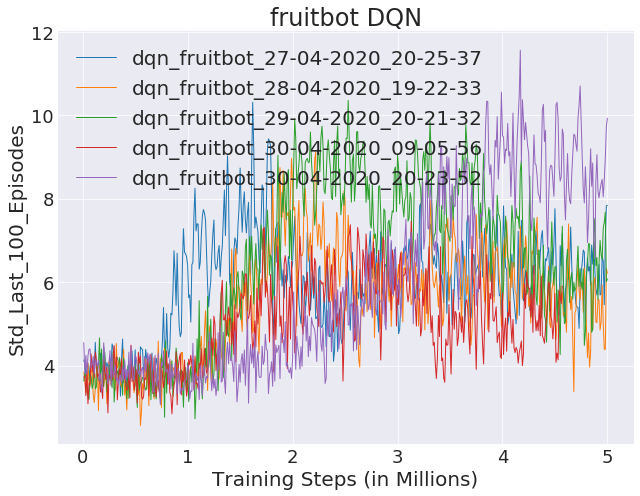

In [134]:
# 5m Timesteps
trials = [
    
    'dqn_fruitbot_27-04-2020_20-25-37',
    'dqn_fruitbot_28-04-2020_19-22-33',
    'dqn_fruitbot_29-04-2020_20-21-32',
    'dqn_fruitbot_30-04-2020_09-05-56', # This was a weird trial, 10m timesteps but cutoff at 4.5m
    'dqn_fruitbot_30-04-2020_20-23-52'
]

plot(logdir='data_dqn', env='fruitbot', double_q=False, trials=trials, sma=True)
plot(logdir='data_dqn', env='fruitbot', double_q=False, trials=trials, col_name='Std_Last_100_Episodes', sma=True)

As evident by the above graph, the standard deviation get's relatively large after 1 million timesteps. This is likely because of the piecewise linear function that is our epsilon decay rate. Because we erroneously had the epsilons set to 0.01 by 1e6 timestep, we do not explore much after that, and exploit for 4 million timesteps. However, this is too much exploitation, and we modified the peicewise function to decay at a slower rate, resulting in more exploration. 

How do we explain the spikes?
    - Epsilon exploration rate decreasing too fast, we are exploiting too soon. 


Two things we could try to improve the performance:
- Increase the size of the replay buffer from 1m to 2m. 
    * However, we must be careful with the size of the experience replay:
        - https://www.endtoend.ai/slowpapers/cer/: "Although most research has used the default size of 10^6 for the replay buffer, Experience Replay is sensitive to replay buffer size, with huge performance drops for buffers too small or too large."
- Change the epsilon decay, because towards the end of the 5m/10m tests, or even halfway through, epsilon is already as low as 0.01!
    * The new
- How does num_levels affect our result? Maybe just stick with 50 levels for now. 
    * 250 and 500 may be too many levels for our number of timesteps. 
    
- Are we constantly changing seeds?

Logistical things maybe worth mentioning to fatten up our report:
    - The machine on GCP
    - How to use cron to efficiently use GCP
    - The best practices for GCP
    - Using tmux on GCP
    
    - Increased size of experience replay requires lot's of extra memory which is prohibitively expensive. 
    - How to make experience replay less memory hungry?

Miscellaneous:
    - We misinterpreted the prompt with respect to the number of timesteps per level.

Parameters used:
    * Batch size: 32, 128 might be more suitable on the K80
        - Batch size: 32 Time taken per 10,000
    * The GPU memory doesn't seem to be fully utilized. 
        - We could make the size of the CNN larger...